## Data Cleaning and EDA


In [120]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import regex as re
from bs4 import BeautifulSoup  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [121]:
run = pd.read_csv("./running.csv")

In [122]:
mar = pd.read_csv("./firstm.csv")

In [123]:
run.head()

,subreddit,selftext,title
0,running,Hi\n\nI bought a second hand treadmill (SS255 ...,Treadmill question - Orbit Starstrider 255
1,running,"Hi, im couch potato and I have been working ou...",If I run everyday will I die faster?
2,running,[removed],Couch to marathon in 3 months
3,running,I just started running again after being sick ...,Encouragement for future?
4,running,Hey fellow runners! :). \n\nI started running ...,Knee stiffness from running


In [124]:
mar.head()

,subreddit,selftext,title
0,firstmarathon,[removed],First Marathon
1,firstmarathon,hey there! training for my first marathon (Ric...,strength work (preferably body weight or dumbb...
2,firstmarathon,At this point I have done almost everything th...,Looking for some Internet Karma + Confidence: ...
3,firstmarathon,Hey ya’ll\n\nSo about 14 weeks out from this o...,Plan for Toronto Waterfront Marathon
4,firstmarathon,I can't find anyone online that experiences ch...,Chafing in a rather uncomfortable area... any ...


### Data Cleaning

In [125]:
#defining function for processing DataFrame
def df_prep(df):
    
   
    df["selftext"].fillna("",inplace = True)  # fill null in "selftext" with empty string
    df["selftext"].replace("[removed]"," ", inplace = True) # replaced [removed] in "selftext" with empty string
    df["selftext"].replace("[deleted]"," ", inplace = True) # replaced [deleted] in "selftext" with empty string
    df["atext"] = df["title"] + " "  + df["selftext"] # creating new "atext" column by concating "title" and "selftext"
    df.drop(columns = ["selftext","title"], axis =1, inplace =True) # drop the now redundant "selftext" and "title"
    df.drop_duplicates(subset = ['atext'], keep = 'first',inplace =True) #check and drop duplicates
    print(df.shape) #check shape to make sure we have enough data points
    print(df.isnull().sum()) #check if we miss out any null values
    
    return df
    

In [126]:
# Processing the running dataset

df_prep(run)

(1770, 2)
subreddit    0
atext        0
dtype: int64


,subreddit,atext
0,running,Treadmill question - Orbit Starstrider 255 Hi\...
1,running,"If I run everyday will I die faster? Hi, im co..."
2,running,Couch to marathon in 3 months
3,running,Encouragement for future? I just started runni...
4,running,Knee stiffness from running Hey fellow runners...
...,...,...
1795,running,Half marathon training while working long hour...
1796,running,Marathon Novice Training - Seeking advice on e...
1797,running,Obliterated my Achilles Tendon in 2020 and hav...
1798,running,Arch pain Hello all!\n\nI’m 25F and have been ...


In [127]:
# Processing the marathon dataset

df_prep(mar)

(1794, 2)
subreddit    0
atext        0
dtype: int64


,subreddit,atext
0,firstmarathon,First Marathon
1,firstmarathon,strength work (preferably body weight or dumbb...
2,firstmarathon,Looking for some Internet Karma + Confidence: ...
3,firstmarathon,Plan for Toronto Waterfront Marathon Hey ya’ll...
4,firstmarathon,Chafing in a rather uncomfortable area... any ...
...,...,...
1795,firstmarathon,Recovery advice Hi all! I'm training for my fi...
1796,firstmarathon,Nutrition plans for training? Hey there /r/fir...
1797,firstmarathon,Race Report: Edmonton International Marathon -...
1798,firstmarathon,First marathon is tomorrow... anything else I ...


In [128]:
# Creating a set of stopwords to be used for processing the 2 DataFrame after EDA

stops = stopwords.words('english')
add_stopwords = ["run", "running", "marathon", "get", "wa", "mile"] # additional words added after EDA

for words in add_stopwords:
    stops.append(words)

In [129]:
# Function to convert a raw review to a string of words
def atext_to_words(column):
    
    # instantiating lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # 1. remove URL with regex
    atext = re.sub(r'http\S+', '', column)
    
    # 2. Remove HTML.
    atext_text = BeautifulSoup(atext).get_text()
    
    # 3. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", atext_text)
    
    # 4. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 5. lemmatize words 
    lem_words = [lemmatizer.lemmatize(i) for i in words]
    
    # 6. Convert the stopwords to a set for faster runs
    stops = set(stopwords.words('english') + add_stopwords)
  
    
    # 6. Remove stopwords.
    meaningful_words = [w for w in lem_words if not w in stops]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

### EDA

In [130]:
#Processing the long string in run dataframe
run['atext'] = run['atext'].map(atext_to_words)

C:\Users\cheon\.conda\envs\dsi30\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


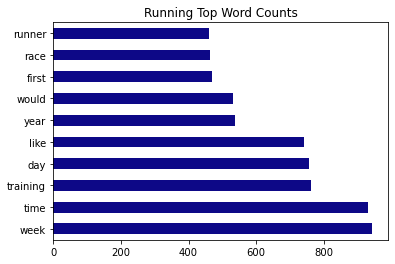

In [131]:
# Plotting words with top counts in run

X = run['atext']
cvec = CountVectorizer()
cvec.fit(X)
X = cvec.transform(X)
X_run_df = pd.DataFrame(X.todense(),
                        columns=cvec.get_feature_names_out())
X_run_df.sum().sort_values(ascending = False).head(10).plot(kind="barh", cmap = "plasma")
plt.title("Running Top Word Counts");

In [132]:
#Processing the long string in marathon dataframe
mar['atext'] = mar['atext'].map(atext_to_words)

C:\Users\cheon\.conda\envs\dsi30\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


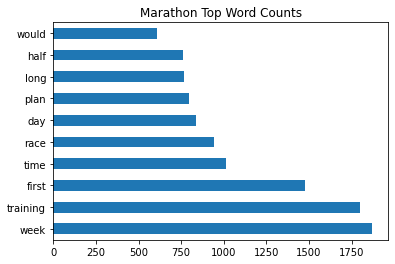

In [133]:
# Plotting words with top counts in marathon

X_mar = mar['atext']
cvec.fit(X_mar)
X_mar = cvec.transform(X_mar)
X_mar_df = pd.DataFrame(X_mar.todense(),
                        columns=cvec.get_feature_names_out())
X_mar_df.sum().sort_values(ascending = False).head(10).plot(kind="barh")
plt.title("Marathon Top Word Counts");

After comparing the two bar chart for top word counts from the running and marathon dataset, we do see a good mix of common words among the two with week and training both in the top 3 spots in terms of word count altough both words appears more often in marathon posts.

Some unique words that are only found in Marathon's top ten list are "long", "plan" and "half". They seem reasonable as first time marathoners are likely to need a training plan, will introduce more long runs in their training and the word "half" probably came from discussion on half marathons.

In [134]:
#Combine the two dataframes for further processing and modelling

df = pd.concat([run,mar])

In [135]:
df.reset_index(inplace = True, drop = True)

In [136]:
# checking the shape

df.shape

(3564, 2)

In [137]:
df.head()

,subreddit,atext
0,running,treadmill question orbit starstrider hi bought...
1,running,everyday die faster hi im couch potato working...
2,running,couch month
3,running,encouragement future started sick year ran f h...
4,running,knee stiffness hey fellow runner started week ...


In [138]:
df.tail()

,subreddit,atext
3559,firstmarathon,recovery advice hi training first full january...
3560,firstmarathon,nutrition plan training hey r firstmarathon ea...
3561,firstmarathon,race report edmonton international first x pos...
3562,firstmarathon,first tomorrow anything else ready finished tr...
3563,firstmarathon,first time k target time currently lb min firs...


## Preprocessing and Modeling


### Preprocessing

In [139]:
# Mapping running as "0" and firstmarathon as "1"
df['subreddit'] = df["subreddit"].map({"running":0,"firstmarathon":1})

In [140]:
# Defining our X and y

X = df['atext'].map(atext_to_words) # mapping the function to process post into a long string
y = df["subreddit"]

In [141]:
# Creating a train test split with 80% train and 20% test data

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

### Modelling

In [142]:
# Instantiating the 2 Vectorizers
cvec = CountVectorizer()
tvec = TfidfVectorizer()

In [143]:
# Instantiating the 5 Classifiers
nb = MultinomialNB()
lr = LogisticRegression()
knn = KNeighborsClassifier()
bg = BaggingClassifier()
rf = RandomForestClassifier()

In [144]:
# Defining a function for modelling

def run_or_mar(vec_name, vec_model, model_name, model, params):
    
    pipe = Pipeline([
        (vec_name, vec_model),
        (model_name, model)])
    
    print(pipe)
    
    gs = GridSearchCV(pipe,
                      param_grid = params,
                      verbose = 1,
                      cv = 5)
    print(gs)
    
    gs.fit(X_train, y_train)
    
    print(f'Optimal parameters for {vec_name}_{model_name} are {gs.best_params_}.')
    print(f'Best score for {vec_name}_{model_name} are {gs.best_score_}.')
    print(f'Train score for {vec_name}_{model_name} is {gs.score(X_train,y_train)}.')
    print(f'Test score for {vec_name}_{model_name} is {gs.score(X_test,y_test)}.')
    
    preds = gs.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cm = confusion_matrix(y_test, preds)
    
    spec = tn / (tn + fp)
    sens = tp / (tp + fn)

    print('Specificity:', spec)
    print('Sensitivity:', sens)
    
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="hot")
    plt.title(f'Confusion Matrix {vec_name}_{model_name}.');
    
    if model_name == "nb":
        
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        log_prob_diff = gs.best_estimator_.steps[1][1].feature_log_prob_[1] - gs.best_estimator_.steps[1][1].feature_log_prob_[0]
        df_coef = pd.DataFrame(log_prob_diff,index=coef1)
        df_coef.columns = ["coef_nb"]
        return df_coef.sort_values(by = ['coef_nb'],ascending = False).head(10)

    elif model_name == "lr":
        
        n_coef3 = gs.best_estimator_[0].get_feature_names_out()
        coef3 = gs.best_estimator_.named_steps.lr.coef_[0]
        coef3 = np.exp(coef3)
        df_coef3 = pd.DataFrame(coef3,index=n_coef3)
        df_coef3.columns = ["coef_lr"]
        return df_coef3.sort_values(by = ['coef_lr'],ascending = False).head(10)
    
    elif model_name == "rf":
        
        n_coef3 = gs.best_estimator_[0].get_feature_names_out()
        coef3 = gs.best_estimator_.named_steps.rf.feature_importances_
        df_coef3 = pd.DataFrame(coef3,index=n_coef3)
        df_coef3.columns = ["coef_rf"]
        return df_coef3.sort_values(by = ['coef_rf'],ascending = False).head(10)
        
    else:
        
        pass
        

In [145]:
# Defining a function for getting model parameters

def param_gen(vec_name, vec_model, model_name, model):
    
    pipe = Pipeline([
        (vec_name, vec_model),
        (model_name, model)])

    return pipe.get_params()
    

#### CountVectorizer NB

In [146]:
# generate parameters to be set for modelling
param_gen('cvec',cvec,'nb',nb)

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [147]:
# Setting parameters for modelling

cvec_nb_params = {
    'cvec__max_features': [5_000], #[2_000, 3_000, 4_000, 5_000, 6_000, 7_000],
    'cvec__min_df': [3], #[2, 3],
    'cvec__max_df':[.9], #[.9, .95],
    'cvec__ngram_range': [(1,2)], #[(1,1), (1,2), (1,3)]
    'nb__alpha': [1.0], #[0.2,0.5,1.0]
}

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'nb__alpha': [1.0]},
             verbose=1)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimal parameters for cvec_nb are {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 1.0}.
Best score for cvec_nb are 0.8021765446892186.
Train score for cvec_nb is 0.8589968432129077.
Test score for cvec_nb is 0.7629733520336606.
Specificity: 0.7711864406779662
Sensitivity: 0.754874651810585


,coef_nb
higdon novice,4.324131
marathoner,3.492397
novice plan,3.464998
hartford,3.282677
chicago,3.100355
registered,3.016974
following hal,2.877212
first sunday,2.825918
san,2.825918
parent,2.825918


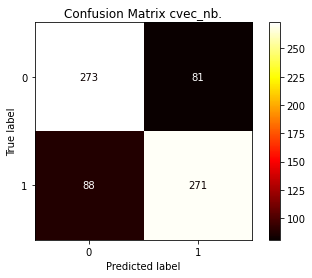

In [148]:
run_or_mar('cvec',cvec,'nb',nb,cvec_nb_params)

#### TfidfVectorizer NB

In [149]:
param_gen('tvec',tvec,'nb',nb)

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [150]:
tvec_nb_params = {
    'tvec__max_features': [4_000], #[2_000, 3_000, 4_000, 5_000]
    'tvec__stop_words': [None], #[None, 'english']
    'tvec__ngram_range': [(1,3)], #[(1,1), (1,2), (1,3)]
    'nb__alpha': [1.0] #[0.1,0.5,1.0]
}

Pipeline(steps=[('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [1.0], 'tvec__max_features': [4000],
                         'tvec__ngram_range': [(1, 3)],
                         'tvec__stop_words': [None]},
             verbose=1)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimal parameters for tvec_nb are {'nb__alpha': 1.0, 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}.
Best score for tvec_nb are 0.7951602298214889.
Train score for tvec_nb is 0.8793405822518414.
Test score for tvec_nb is 0.761570827489481.
Specificity: 0.748587570621469
Sensitivity: 0.7743732590529248


,coef_nb
higdon novice,2.176424
higdon,2.068963
chicago,2.037032
hal,2.002593
hal higdon novice,1.992613
hal higdon,1.961368
taper,1.951290
novice,1.812514
first full,1.760943
miler,1.653291


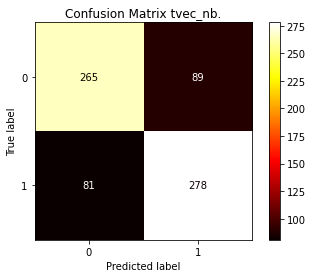

In [151]:
run_or_mar('tvec',tvec, 'nb', nb, tvec_nb_params)

#### CountVectorizer Logistic Regression

In [152]:
param_gen('cvec',cvec,'lr',lr)

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [153]:
cvec_lr_params = {
    'cvec__max_features': [5_000], #[2_000, 3_000, 4_000, 5_000, 6_000]
    'cvec__min_df':  [2], #[2, 3]
    'cvec__max_df':[.9], #[.9, .95]
    'cvec__ngram_range': [(1,3)], #[(1,1), (1,2), (1,3)]
    'lr__max_iter': [5000], #[5000,10000]
    'lr__C': [0.1], #[0.1,0.2,0.5,1.0],
    'lr__solver': ['lbfgs'] #['lbfgs','liblinear','newton-cg']
}

Pipeline(steps=[('cvec', CountVectorizer()), ('lr', LogisticRegression())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 3)],
                         'lr__C': [0.1], 'lr__max_iter': [5000],
                         'lr__solver': ['lbfgs']},
             verbose=1)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimal parameters for cvec_lr are {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'lr__C': 0.1, 'lr__max_iter': 5000, 'lr__solver': 'lbfgs'}.
Best score for cvec_lr are 0.789197775524626.
Train score for cvec_lr is 0.9203788144510698.
Test score for cvec_lr is 0.7671809256661991.
Specificity: 0.7401129943502824
Sensitivity: 0.7938718662952646


,coef_lr
first,2.632438
full,2.086540
finish,1.754257
may,1.715405
chicago,1.681383
april,1.669439
miler,1.560223
finished,1.533050
training,1.516092
nyc,1.496177


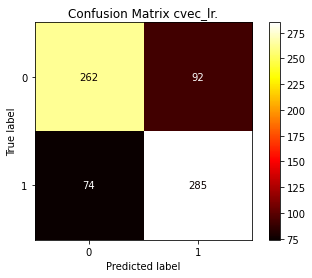

In [154]:
run_or_mar('cvec',cvec,'lr',lr,cvec_lr_params)

#### TfidfVectorizer Logistic Regression 

In [155]:
param_gen('tvec',tvec,'lr',lr)

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'lr': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state

In [156]:
tvec_lr_params = {
    'tvec__max_features': [5_000], #2_000, 3_000, 4_000, 5_000
    'tvec__stop_words': [None], #[None, 'english']
    'tvec__ngram_range': [(1,2)], #(1,1), (1,2). (1,3)
    'lr__max_iter': [5000], #5000, 7000, 10000
    'lr__C': [1.0] #0.1, 0.2, 0.5, 1.0
}

Pipeline(steps=[('tvec', TfidfVectorizer()), ('lr', LogisticRegression())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1.0], 'lr__max_iter': [5000],
                         'tvec__max_features': [5000],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [None]},
             verbose=1)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimal parameters for tvec_lr are {'lr__C': 1.0, 'lr__max_iter': 5000, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}.
Best score for tvec_lr are 0.7888468983316436.
Train score for tvec_lr is 0.8951245177130831.
Test score for tvec_lr is 0.7741935483870968.
Specificity: 0.7994350282485876
Sensitivity: 0.7493036211699164


,coef_lr
first,257.277448
training,55.146112
plan,13.974992
full,11.958030
finish,10.797855
week,8.242533
finished,6.218672
weekend,5.774158
chicago,5.662007
higdon,4.734381


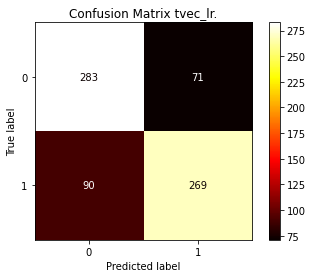

In [157]:
run_or_mar('tvec',tvec,'lr',lr,tvec_lr_params)

#### CountVectorizer KNN

In [158]:
param_gen('cvec',cvec,'knn',knn)

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'knn': KNeighborsClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [159]:
cvec_knn_params = {
    'cvec__max_features': [2_000], #[2_000, 3_000, 4_000, 5_000]
    'cvec__min_df':  [2], #[2, 3]
    'cvec__max_df':[.9], #[.9, .95]
    'cvec__ngram_range': [(1,2)], #(1,1), (1,2)
    'knn__leaf_size': [10] #[10,20,30,40]
}

Pipeline(steps=[('cvec', CountVectorizer()), ('knn', KNeighborsClassifier())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [2000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'knn__leaf_size': [10]},
             verbose=1)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimal parameters for cvec_knn are {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'knn__leaf_size': 10}.
Best score for cvec_knn are 0.6271551909546194.
Train score for cvec_knn is 0.7460540161346896.
Test score for cvec_knn is 0.6199158485273493.
Specificity: 0.3418079096045198
Sensitivity: 0.8941504178272981


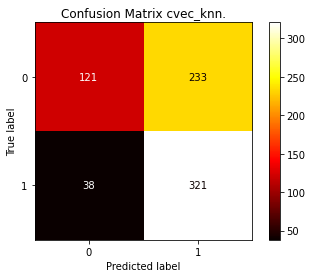

In [160]:
run_or_mar('cvec',cvec,'knn',knn,cvec_knn_params)

#### TfidfVectorizer KNN

In [161]:
param_gen('tvec',tvec,'knn',knn)

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'knn': KNeighborsClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [162]:
tvec_knn_params = {
    'tvec__max_features': [2_000], #[2_000, 3_000, 4_000, 5_000]
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,2)], #[(1,1), (1,2)]
    'knn__leaf_size': [2] #[2,3,5,10,20,30]
}

Pipeline(steps=[('tvec', TfidfVectorizer()), ('knn', KNeighborsClassifier())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__leaf_size': [2], 'tvec__max_features': [2000],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimal parameters for tvec_knn are {'knn__leaf_size': 2, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}.
Best score for tvec_knn are 0.5454247703321351.
Train score for tvec_knn is 0.6762539459838653.
Test score for tvec_knn is 0.5385694249649369.
Specificity: 0.2570621468926554
Sensitivity: 0.8161559888579387


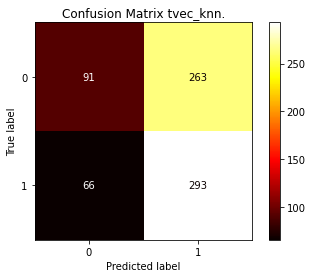

In [163]:
run_or_mar('tvec',tvec,'knn',knn,tvec_knn_params)

#### CountVectorizer Bagging

In [164]:
param_gen('cvec',cvec,'bg',bg)

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('bg', BaggingClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'bg': BaggingClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'bg__base_estimator': None,
 'bg__bootstrap': True,
 'bg__bootstrap_features': False,
 'bg__max_features': 1.0,
 'bg__max_samples': 1.0,
 'bg__n_estimators': 10,
 'bg__n_jobs': None,
 'bg__oob_score': False,
 'bg__random_state': None,
 'bg__verbose': 0,
 'bg__warm_start': False}

In [165]:
cvec_bg_params = {
    'cvec__max_features': [5_000], #[2_000, 3_000, 4_000, 5_000]
    'cvec__min_df':  [2], #2, 3
    'cvec__max_df':[.9], #.9, .95
    'cvec__ngram_range': [(1,2)], #(1,2), (1,1)
    'bg__n_estimators': [10], #[5, 10, 15]
    'bg__n_jobs': [-1]

}

Pipeline(steps=[('cvec', CountVectorizer()), ('bg', BaggingClassifier())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bg', BaggingClassifier())]),
             param_grid={'bg__n_estimators': [10], 'bg__n_jobs': [-1],
                         'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)]},
             verbose=1)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimal parameters for cvec_bg are {'bg__n_estimators': 10, 'bg__n_jobs': -1, 'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}.
Best score for cvec_bg are 0.7323839370756138.
Train score for cvec_bg is 0.9817607856892319.
Test score for cvec_bg is 0.7068723702664796.
Specificity: 0.7005649717514124
Sensitivity: 0.713091922005571


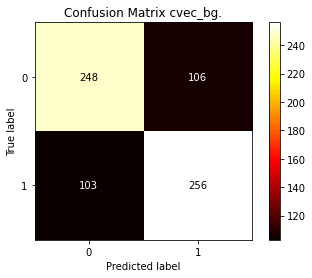

In [166]:
run_or_mar('cvec',cvec,'bg',bg,cvec_bg_params)

#### CountVectorizer Random Forest

In [167]:
param_gen('cvec',cvec,'rf',rf)

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_est

In [168]:
cvec_rf_params = {
    'cvec__max_features': [4_000], #[2_000, 3_000, 4_000, 5_000]
    'cvec__min_df':  [3], #2, 3
    'cvec__max_df':[.9], #.9, .95
    'cvec__ngram_range': [(1,1),(1,2)], #(1,2), (1,1)
    'rf__n_estimators': [300], #[100, 200, 300]
    'rf__max_depth': [5], #[3,4,5]
    'rf__n_jobs': [-1]
}

Pipeline(steps=[('cvec', CountVectorizer()), ('rf', RandomForestClassifier())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [4000],
                         'cvec__min_df': [3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [5], 'rf__n_estimators': [300],
                         'rf__n_jobs': [-1]},
             verbose=1)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimal parameters for cvec_rf are {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'rf__max_depth': 5, 'rf__n_estimators': 300, 'rf__n_jobs': -1}.
Best score for cvec_rf are 0.7544603189234029.
Train score for cvec_rf is 0.791301297790249.
Test score for cvec_rf is 0.726507713884993.
Specificity: 0.7627118644067796

,coef_rf
training,0.059287
first,0.045742
week,0.022729
finish,0.022172
plan,0.021857
novice,0.021753
full,0.018913
hal,0.018738
higdon,0.015178
runner,0.015008


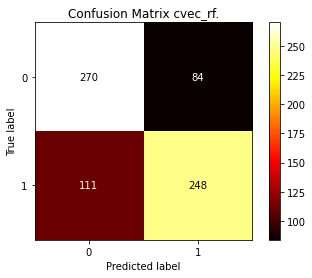

In [169]:
run_or_mar('cvec',cvec,'rf',rf,cvec_rf_params)

#### TfidfVectorizer Random Forest

In [170]:
param_gen("tvec",tvec,"rf",rf)

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 '

In [171]:
tvec_rf_params = {
    'tvec__max_features': [4_000], #[2_000, 3_000, 4_000, 5_000]
    'tvec__stop_words': [None], #[None, 'english']
    'tvec__ngram_range': [(1,2)], #[(1,1), (1,2)]
    'rf__n_estimators': [300], #[100, 200, 300]
    'rf__max_depth': [5], #[3,4,5]
    'rf__n_jobs': [-1]
}

Pipeline(steps=[('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())])
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [5], 'rf__n_estimators': [300],
                         'rf__n_jobs': [-1], 'tvec__max_features': [4000],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [None]},
             verbose=1)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimal parameters for tvec_rf are {'rf__max_depth': 5, 'rf__n_estimators': 300, 'rf__n_jobs': -1, 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}.
Best score for tvec_rf are 0.7544646203951209.
Train score for tvec_rf is 0.7969133637320238.
Test score for tvec_rf is 0.7152875175315568.
Specificity: 0.7909604519774012
Sensitivity: 0.6406685236768802


,coef_rf
first,0.048621
higdon,0.036567
training,0.032428
plan,0.029094
hal,0.025594
finish,0.025454
full,0.019415
novice,0.019004
training plan,0.017796
hal higdon,0.016827


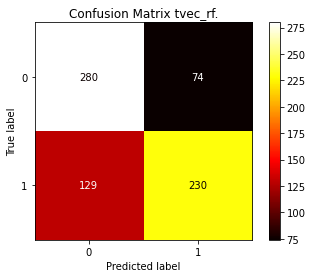

In [172]:
run_or_mar("tvec",tvec,"rf",rf,tvec_rf_params)

#### Baseline Model

In [173]:
# Construct a baseline model for comparison

y.value_counts(normalize = True)

1    0.503367
0    0.496633
Name: subreddit, dtype: float64

Accuracy: 0.5035063113604488
Specificity: 0.0
Sensitivity: 1.0


Text(0.5, 1.0, 'Confusion Matrix Baseline Model')

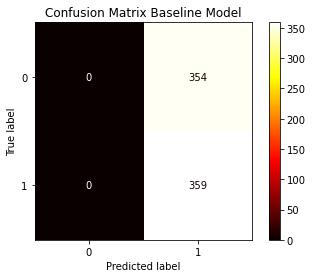

In [174]:
# all preds are "marathon" as it has higher count
preds = [1]*len(y_test)
    
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)
    
accr = (tn+tp)/(tn+tp+fn+fp)
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print('Accuracy:', accr)
print('Specificity:', spec)
print('Sensitivity:', sens)
    
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="hot")
plt.title("Confusion Matrix Baseline Model")

In the baseline model, we will classify all post as "marathon" represented by "1" since it has a higher count. The baseline model has a accuracy of 50.3%, as expected since 50.3% of the post are from the "marathon" subbreddit.

## Model Evaluation


|    |   **Vectorizer** |      **Classifier** | **Train** | **Test** | **Train-Test** | **Best Score** | **Specificity** | **Sensitivity** |
|---:|-----------------:|--------------------:|-----------|----------|----------------|----------------|-----------------|-----------------|
| 1  | Baseline         | Baseline            | NA        | NA       | NA             | 0.503          | 0.0              | 1.0              |
| 2  | Count Vectorizer | Naive Bayers        | 0.859     | 0.763    | 0.096          | **0.802**      | 0.771           | 0.755           |
| 3  | Tfidf Vectorizer | Naive Bayers        | 0.879     | 0.762    | 0.117          | 0.795          | 0.749           | 0.774           |
| 4  | Count Vectorizer | Logistic Regression | 0.920     | 0.767    | 0.153          | 0.789          | 0.740           | 0.794           |
| 5  | Tfidf Vectorizer | Logistic Regression | 0.895     | 0.774    | 0.121          | 0.789          | **0.799**       | 0.749           |
| 6  | Count Vectorizer | K Nearest Neighbor  | 0.746     | 0.620    | 0.126          | 0.627          | 0.342           | **0.894**       |
| 7  | Tfidf Vectorizer | K Nearest Neighbor  | 0.676     | 0.539    | 0.137          | 0.545          | 0.257           | 0.816           |
| 8  | Count Vectorizer | Bagging             | 0.980     | 0.718    | 0.262          | 0.732          | 0.698           | 0.738           |
| 9  | Count Vectorizer | Random Forest       | 0.791     | 0.727    | **0.064**      | 0.754          | 0.777           | 0.652           |
| 10 | Tfidf Vectorizer | Random Forest       | 0.797     | 0.715    | 0.082          | 0.754          | 0.790           | 0.643           |

<img src="./images/dsi30_cm_compare.jpg" />

With reference to the table above that compares the baseline model with all the other classification models constructed, model 2 (CountVectorizer Naive Bayers) is our model of choice since it acheived the highest accuracy score of 0.802 while maintaining a small overfitting problem relative to the other models.

While model 9 (CountVectorizer Random Forest) does not overfit as much compared to our choice model, it does not score as well in terms of accuracy and the model tends to lean towards classifying "0" or "running" as reflected by the lower sensitivity score. The weakness of model 9 is also highlighted by the red box in the confusion matrix which shows a disporportionate high number of false negatives.

When compared to the baseline model, we also observe a good improvement in terms of the accuracy score from 0.503 for the baseline and 0.802 for our choice model. This further justifies that our model will be useful in helping classify marathon and general running contents.

## Conclusion and Recommendations

In conclusion, after fitting our data into nine different models and tuning their parameters, we will recommend the management of Running Lab to adopt Model 2 (CountVectorizer Naive Bayers) as the classifier model for classifying marathon content and running content base on the overall performance of the model.


<img src="./images/coef_compare_high.jpg" width=600 height=600/>

We also observe the consistent appearance of Hal Higdon in as meaningful words used by the various models experimented, including our choice model. It suggest that many first time marathoners seems to be keen on following his training programs or at least, have queries and discussions about them. Running Lab may want to look into the training plans and running content provided on Hal Higdon's website so gain insight on what product and services might iterest the marathoners.

Running lab may also want to explore the possibility of co-branding possibilities with Hal Higdon to really establish itself as a running and marathon speciality store, differentiating itself from the competition.

#### Future Works

While our recommended model acheived a good accuracy score of 0.802, we given more time and resource to scrap more data, it is possible better train and further improve on the model's peformance.

Running Lab may also want to consider reading in more localized data such as from HardwareZone.sg forum as reddit is still a predominantly US based forum.

we may also want to dig deeper into the other meaningful words used by the models to derive more insights about what seperates discussions on marathons and normal running.